# Interpretability tutorial

In this tutorial we will go through several popular visualization techniques that help interpret deep learning networks.

We will cover:
1. Filter visualization
2. Feature/ activation visualization
3. CNN Layer Visualization
4. Gradient visualization with Guided backpropagation
5. Class Activation Maps
6. Deep dream

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np 
import visualizations
from visualizations.src.guided_backprop import GuidedBackprop
from visualizations.src.misc_functions import *
from visualizations.src.cnn_layer_visualization import CNNLayerVisualization
from visualizations.src.gradcam import GradCam
from visualizations.src.deep_dream import DeepDream


## 1. Filter Visualization

https://towardsdatascience.com/visualizing-convolution-neural-networks-using-pytorch-3dfa8443e74e

https://colab.research.google.com/github/Niranjankumar-c/DeepLearning-PadhAI/blob/master/DeepLearning_Materials/6_VisualizationCNN_Pytorch/CNNVisualisation.ipynb#scrollTo=uQI9jHcP6xfP

One of the first things you can visualize in your network - is your network filters, or weights.
Your convolutional kernels have weights which are updated during training, and can be visualized by calling the weight data inside your network.

Let's first load and print a pretrained network using pytorch.models:

In [2]:
# first load pretrained alxenet model
alexnet = models.alexnet(pretrained=True)
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

We can see that the network is made up of two sequential models - features, and classifier.

To visualize the convolutional weights, we need to access a convolutional layer in the features model.

This can be done in the following way:
```python 
weight_tensor = model.features[layer_num].weight.data
```
**Note that layer_num should correspond to a convolutional layer - otherwise there are no weights to be visualized.**

We will now define a few functions to help with plotting:

In [3]:
def plot_filters_single_channel(t):
    
    kernels_to_plot = 30
    channels_to_plot = 3
    #kernels depth * number of kernels
    nplots = channels_to_plot*kernels_to_plot
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(kernels_to_plot):
        for j in range(channels_to_plot):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()    

    
def plot_filters_multi_channel(t):
    
    kernels_to_plot = 60
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = kernels_to_plot // num_cols
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(kernels_to_plot):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.tight_layout()
    plt.show()
    


We next define our plot weights function, which first extracts the weights of a convolutional filter, and then passes into an appropriate image plotting function.

In [4]:
def plot_weights(model, layer_num, single_channel = True):
    #extracting the model features at the particular layer number
    layer = model.features[layer_num]
  
    #checking whether the layer is convolution layer or not 

    if isinstance(layer, nn.Conv2d):
        #getting the weight tensor data
        weight_tensor = model.features[layer_num].weight.data
    
        if single_channel:
            plot_filters_single_channel(weight_tensor)
        
        else:
            if weight_tensor.shape[1] == 3:
                plot_filters_multi_channel(weight_tensor)
            else:
                print("Can only plot weights with three channels with single channel = False")
        
    else:
        print("Can only visualize layers which are convolutional")
    

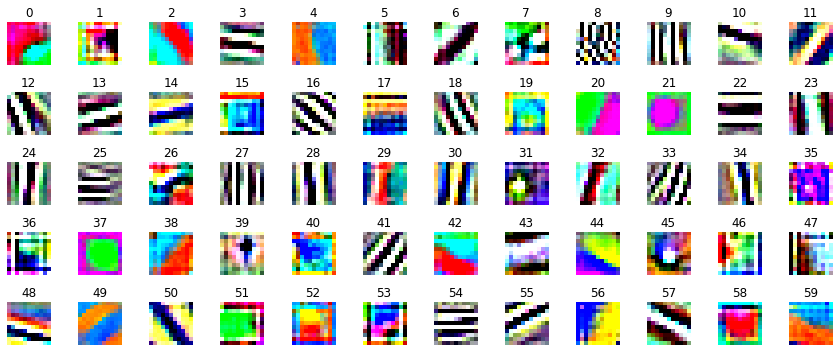

In [5]:
#visualize weights for alexnet - first conv layer
plot_weights(alexnet, 0, single_channel = False)


### Task 1: Visualize the filters of different convolutional layers

Use the plot_weights() function to visualize filters of different convolutional layers.

Note that you can plot single channels if you set single_channel=True (if the filters have 3 channels)


In [6]:
# --------------------------------------------- Task 1 --------------------------------------------------------
# write code here


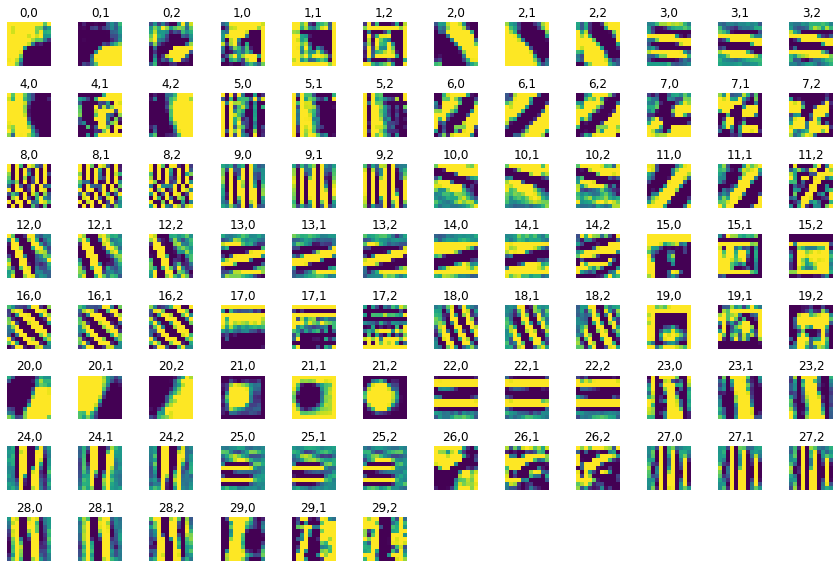

In [6]:
plot_weights(alexnet, 0, single_channel = True)

## 2. Activation visualization

Another effective approach to examine what your network is learning, is the visualize your network's features or activations, i.e. intermediate outputs of your network for a specific inputs.

In the following example, we set up a simple autoencoder network, a network that learns to reconstruct an input, using the MNIST dataset. 

https://discuss.pytorch.org/t/visualize-feature-map/29597/2

### Set up and train a simple autoencoder
We first set up the network, dataset (MNIST using torchvision), optimizer, and loss function. 

In [7]:
class SimpleAutoencoder(nn.Module):
    def __init__(self):
        super(SimpleAutoencoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 3, 1, 1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(3, 6, 3, 1, 1)
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv_trans1 = nn.ConvTranspose2d(6, 3, 4, 2, 1)
        self.conv_trans2 = nn.ConvTranspose2d(3, 1, 4, 2, 1)
        
    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))        
        x = F.relu(self.conv_trans1(x))
        x = self.conv_trans2(x)
        return x

# normalisation - for plotting output
def min_max_norm(img):
    img = img - img.min()
    img = img / img.max()
    return img

dataset = datasets.MNIST(
    root="data",download=True,
    transform=transforms.ToTensor()
)
loader = DataLoader(
    dataset,
    num_workers=2,
    batch_size=8,
    shuffle=True
)

# initialize the network, loss function and optimizer 
model = SimpleAutoencoder()
criterion_l1 = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


Train our simple network on MNIST

In [8]:
epochs = 1
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion_l1(output, data)
        loss.backward()
        optimizer.step()
        
        print('Epoch {}, Iteration {}, loss {}'.format(
            epoch, batch_idx, loss.item()))


Epoch 0, Iteration 0, loss 0.6348254084587097
Epoch 0, Iteration 1, loss 0.6285704970359802
Epoch 0, Iteration 2, loss 0.6313198804855347
Epoch 0, Iteration 3, loss 0.6310322880744934
Epoch 0, Iteration 4, loss 0.6270097494125366
Epoch 0, Iteration 5, loss 0.6337064504623413
Epoch 0, Iteration 6, loss 0.6301491260528564
Epoch 0, Iteration 7, loss 0.6276154518127441
Epoch 0, Iteration 8, loss 0.6285209059715271
Epoch 0, Iteration 9, loss 0.6326495409011841
Epoch 0, Iteration 10, loss 0.6314617991447449
Epoch 0, Iteration 11, loss 0.623255729675293
Epoch 0, Iteration 12, loss 0.6296166181564331
Epoch 0, Iteration 13, loss 0.6224399209022522
Epoch 0, Iteration 14, loss 0.6315367817878723
Epoch 0, Iteration 15, loss 0.6234452128410339
Epoch 0, Iteration 16, loss 0.6265631914138794
Epoch 0, Iteration 17, loss 0.6298623085021973
Epoch 0, Iteration 18, loss 0.6206440925598145
Epoch 0, Iteration 19, loss 0.6261599063873291
Epoch 0, Iteration 20, loss 0.6243453621864319
Epoch 0, Iteration 21, l

Epoch 0, Iteration 172, loss 0.36754778027534485
Epoch 0, Iteration 173, loss 0.3600846529006958
Epoch 0, Iteration 174, loss 0.3870384097099304
Epoch 0, Iteration 175, loss 0.38670217990875244
Epoch 0, Iteration 176, loss 0.3649468421936035
Epoch 0, Iteration 177, loss 0.31961724162101746
Epoch 0, Iteration 178, loss 0.38371482491493225
Epoch 0, Iteration 179, loss 0.38984188437461853
Epoch 0, Iteration 180, loss 0.3640240728855133
Epoch 0, Iteration 181, loss 0.43069741129875183
Epoch 0, Iteration 182, loss 0.4341157078742981
Epoch 0, Iteration 183, loss 0.3918417990207672
Epoch 0, Iteration 184, loss 0.34515923261642456
Epoch 0, Iteration 185, loss 0.3637409210205078
Epoch 0, Iteration 186, loss 0.38860827684402466
Epoch 0, Iteration 187, loss 0.357237845659256
Epoch 0, Iteration 188, loss 0.40182122588157654
Epoch 0, Iteration 189, loss 0.3995527923107147
Epoch 0, Iteration 190, loss 0.38663384318351746
Epoch 0, Iteration 191, loss 0.4120139181613922
Epoch 0, Iteration 192, loss 0.

Epoch 0, Iteration 341, loss 0.2103257030248642
Epoch 0, Iteration 342, loss 0.25060686469078064
Epoch 0, Iteration 343, loss 0.265010803937912
Epoch 0, Iteration 344, loss 0.22090178728103638
Epoch 0, Iteration 345, loss 0.22668230533599854
Epoch 0, Iteration 346, loss 0.25625523924827576
Epoch 0, Iteration 347, loss 0.23224571347236633
Epoch 0, Iteration 348, loss 0.22186535596847534
Epoch 0, Iteration 349, loss 0.18866661190986633
Epoch 0, Iteration 350, loss 0.2275070995092392
Epoch 0, Iteration 351, loss 0.21785970032215118
Epoch 0, Iteration 352, loss 0.2385154515504837
Epoch 0, Iteration 353, loss 0.2230573445558548
Epoch 0, Iteration 354, loss 0.21420884132385254
Epoch 0, Iteration 355, loss 0.23661842942237854
Epoch 0, Iteration 356, loss 0.19082927703857422
Epoch 0, Iteration 357, loss 0.2147730588912964
Epoch 0, Iteration 358, loss 0.22068139910697937
Epoch 0, Iteration 359, loss 0.21257436275482178
Epoch 0, Iteration 360, loss 0.21888823807239532
Epoch 0, Iteration 361, los

Epoch 0, Iteration 509, loss 0.11136052757501602
Epoch 0, Iteration 510, loss 0.14801405370235443
Epoch 0, Iteration 511, loss 0.13407941162586212
Epoch 0, Iteration 512, loss 0.11809766292572021
Epoch 0, Iteration 513, loss 0.15136182308197021
Epoch 0, Iteration 514, loss 0.11088959127664566
Epoch 0, Iteration 515, loss 0.12916722893714905
Epoch 0, Iteration 516, loss 0.15258942544460297
Epoch 0, Iteration 517, loss 0.13278129696846008
Epoch 0, Iteration 518, loss 0.13387221097946167
Epoch 0, Iteration 519, loss 0.1314876228570938
Epoch 0, Iteration 520, loss 0.13451600074768066
Epoch 0, Iteration 521, loss 0.1475435197353363
Epoch 0, Iteration 522, loss 0.12236731499433517
Epoch 0, Iteration 523, loss 0.12621530890464783
Epoch 0, Iteration 524, loss 0.13862593472003937
Epoch 0, Iteration 525, loss 0.13079342246055603
Epoch 0, Iteration 526, loss 0.12348296493291855
Epoch 0, Iteration 527, loss 0.1428929567337036
Epoch 0, Iteration 528, loss 0.1587570309638977
Epoch 0, Iteration 529, 

Epoch 0, Iteration 677, loss 0.12553779780864716
Epoch 0, Iteration 678, loss 0.09561379998922348
Epoch 0, Iteration 679, loss 0.10519446432590485
Epoch 0, Iteration 680, loss 0.1026143953204155
Epoch 0, Iteration 681, loss 0.08242662250995636
Epoch 0, Iteration 682, loss 0.107757568359375
Epoch 0, Iteration 683, loss 0.11552736908197403
Epoch 0, Iteration 684, loss 0.1183105856180191
Epoch 0, Iteration 685, loss 0.1265830248594284
Epoch 0, Iteration 686, loss 0.12152687460184097
Epoch 0, Iteration 687, loss 0.12085630744695663
Epoch 0, Iteration 688, loss 0.11418790370225906
Epoch 0, Iteration 689, loss 0.110185407102108
Epoch 0, Iteration 690, loss 0.11490824073553085
Epoch 0, Iteration 691, loss 0.09210579842329025
Epoch 0, Iteration 692, loss 0.10056553781032562
Epoch 0, Iteration 693, loss 0.10865265876054764
Epoch 0, Iteration 694, loss 0.10879293829202652
Epoch 0, Iteration 695, loss 0.10908079147338867
Epoch 0, Iteration 696, loss 0.12248274683952332
Epoch 0, Iteration 697, los

Epoch 0, Iteration 844, loss 0.11488249152898788
Epoch 0, Iteration 845, loss 0.11067177355289459
Epoch 0, Iteration 846, loss 0.09452642500400543
Epoch 0, Iteration 847, loss 0.10813083499670029
Epoch 0, Iteration 848, loss 0.10251645743846893
Epoch 0, Iteration 849, loss 0.10092518478631973
Epoch 0, Iteration 850, loss 0.11800981312990189
Epoch 0, Iteration 851, loss 0.10478764027357101
Epoch 0, Iteration 852, loss 0.1091213971376419
Epoch 0, Iteration 853, loss 0.10294316709041595
Epoch 0, Iteration 854, loss 0.11564551293849945
Epoch 0, Iteration 855, loss 0.09865827858448029
Epoch 0, Iteration 856, loss 0.11298573017120361
Epoch 0, Iteration 857, loss 0.11186625063419342
Epoch 0, Iteration 858, loss 0.10114747285842896
Epoch 0, Iteration 859, loss 0.12054399400949478
Epoch 0, Iteration 860, loss 0.10430069267749786
Epoch 0, Iteration 861, loss 0.0998803973197937
Epoch 0, Iteration 862, loss 0.10179656744003296
Epoch 0, Iteration 863, loss 0.11223195493221283
Epoch 0, Iteration 864

Epoch 0, Iteration 1011, loss 0.11556771397590637
Epoch 0, Iteration 1012, loss 0.09548422694206238
Epoch 0, Iteration 1013, loss 0.10804351419210434
Epoch 0, Iteration 1014, loss 0.0902850553393364
Epoch 0, Iteration 1015, loss 0.10015826672315598
Epoch 0, Iteration 1016, loss 0.10280581563711166
Epoch 0, Iteration 1017, loss 0.09996567666530609
Epoch 0, Iteration 1018, loss 0.0845034271478653
Epoch 0, Iteration 1019, loss 0.1026119515299797
Epoch 0, Iteration 1020, loss 0.12160035222768784
Epoch 0, Iteration 1021, loss 0.07814908027648926
Epoch 0, Iteration 1022, loss 0.09174354374408722
Epoch 0, Iteration 1023, loss 0.10682976245880127
Epoch 0, Iteration 1024, loss 0.10603322833776474
Epoch 0, Iteration 1025, loss 0.09472716599702835
Epoch 0, Iteration 1026, loss 0.10222177952528
Epoch 0, Iteration 1027, loss 0.10276806354522705
Epoch 0, Iteration 1028, loss 0.10672535002231598
Epoch 0, Iteration 1029, loss 0.08544202893972397
Epoch 0, Iteration 1030, loss 0.10824152827262878
Epoch 

Epoch 0, Iteration 1175, loss 0.09319118410348892
Epoch 0, Iteration 1176, loss 0.09509086608886719
Epoch 0, Iteration 1177, loss 0.09364954382181168
Epoch 0, Iteration 1178, loss 0.10352858901023865
Epoch 0, Iteration 1179, loss 0.09677667170763016
Epoch 0, Iteration 1180, loss 0.09700840711593628
Epoch 0, Iteration 1181, loss 0.09850708395242691
Epoch 0, Iteration 1182, loss 0.09313641488552094
Epoch 0, Iteration 1183, loss 0.07121331244707108
Epoch 0, Iteration 1184, loss 0.09844188392162323
Epoch 0, Iteration 1185, loss 0.10931289196014404
Epoch 0, Iteration 1186, loss 0.10364730656147003
Epoch 0, Iteration 1187, loss 0.08876193314790726
Epoch 0, Iteration 1188, loss 0.10222600400447845
Epoch 0, Iteration 1189, loss 0.09373029321432114
Epoch 0, Iteration 1190, loss 0.09088677167892456
Epoch 0, Iteration 1191, loss 0.10142602771520615
Epoch 0, Iteration 1192, loss 0.09662799537181854
Epoch 0, Iteration 1193, loss 0.10062526911497116
Epoch 0, Iteration 1194, loss 0.09629328548908234


Epoch 0, Iteration 1339, loss 0.08818666636943817
Epoch 0, Iteration 1340, loss 0.1048239916563034
Epoch 0, Iteration 1341, loss 0.09808435291051865
Epoch 0, Iteration 1342, loss 0.10291922092437744
Epoch 0, Iteration 1343, loss 0.10218169540166855
Epoch 0, Iteration 1344, loss 0.09391426295042038
Epoch 0, Iteration 1345, loss 0.08732222765684128
Epoch 0, Iteration 1346, loss 0.09910943359136581
Epoch 0, Iteration 1347, loss 0.11236535012722015
Epoch 0, Iteration 1348, loss 0.0991990715265274
Epoch 0, Iteration 1349, loss 0.0843542143702507
Epoch 0, Iteration 1350, loss 0.0993422269821167
Epoch 0, Iteration 1351, loss 0.08734451234340668
Epoch 0, Iteration 1352, loss 0.09721008688211441
Epoch 0, Iteration 1353, loss 0.09423042088747025
Epoch 0, Iteration 1354, loss 0.09583733230829239
Epoch 0, Iteration 1355, loss 0.10626430809497833
Epoch 0, Iteration 1356, loss 0.1132882833480835
Epoch 0, Iteration 1357, loss 0.10875601321458817
Epoch 0, Iteration 1358, loss 0.08353852480649948
Epoch

Epoch 0, Iteration 1503, loss 0.09068040549755096
Epoch 0, Iteration 1504, loss 0.09519853442907333
Epoch 0, Iteration 1505, loss 0.10506365448236465
Epoch 0, Iteration 1506, loss 0.09325893223285675
Epoch 0, Iteration 1507, loss 0.10086683183908463
Epoch 0, Iteration 1508, loss 0.09909076988697052
Epoch 0, Iteration 1509, loss 0.0902629867196083
Epoch 0, Iteration 1510, loss 0.1032363772392273
Epoch 0, Iteration 1511, loss 0.09012202173471451
Epoch 0, Iteration 1512, loss 0.10050119459629059
Epoch 0, Iteration 1513, loss 0.0942518562078476
Epoch 0, Iteration 1514, loss 0.10460416972637177
Epoch 0, Iteration 1515, loss 0.0861101821064949
Epoch 0, Iteration 1516, loss 0.10096708685159683
Epoch 0, Iteration 1517, loss 0.09749696403741837
Epoch 0, Iteration 1518, loss 0.08967771381139755
Epoch 0, Iteration 1519, loss 0.10746316611766815
Epoch 0, Iteration 1520, loss 0.08763567358255386
Epoch 0, Iteration 1521, loss 0.09397860616445541
Epoch 0, Iteration 1522, loss 0.0891844853758812
Epoch

Epoch 0, Iteration 1667, loss 0.0896543562412262
Epoch 0, Iteration 1668, loss 0.101348377764225
Epoch 0, Iteration 1669, loss 0.1020079031586647
Epoch 0, Iteration 1670, loss 0.10780557990074158
Epoch 0, Iteration 1671, loss 0.10068737715482712
Epoch 0, Iteration 1672, loss 0.10391005873680115
Epoch 0, Iteration 1673, loss 0.09414475411176682
Epoch 0, Iteration 1674, loss 0.08972461521625519
Epoch 0, Iteration 1675, loss 0.08960254490375519
Epoch 0, Iteration 1676, loss 0.0904030129313469
Epoch 0, Iteration 1677, loss 0.08710607886314392
Epoch 0, Iteration 1678, loss 0.09351661056280136
Epoch 0, Iteration 1679, loss 0.09655743092298508
Epoch 0, Iteration 1680, loss 0.10898500680923462
Epoch 0, Iteration 1681, loss 0.10725156962871552
Epoch 0, Iteration 1682, loss 0.08391895145177841
Epoch 0, Iteration 1683, loss 0.09449392557144165
Epoch 0, Iteration 1684, loss 0.10569554567337036
Epoch 0, Iteration 1685, loss 0.0786585733294487
Epoch 0, Iteration 1686, loss 0.10180657356977463
Epoch 

Epoch 0, Iteration 1831, loss 0.10125093907117844
Epoch 0, Iteration 1832, loss 0.09335276484489441
Epoch 0, Iteration 1833, loss 0.0867125391960144
Epoch 0, Iteration 1834, loss 0.10528571903705597
Epoch 0, Iteration 1835, loss 0.0974414125084877
Epoch 0, Iteration 1836, loss 0.08324044197797775
Epoch 0, Iteration 1837, loss 0.1023557260632515
Epoch 0, Iteration 1838, loss 0.10323495417833328
Epoch 0, Iteration 1839, loss 0.09630467742681503
Epoch 0, Iteration 1840, loss 0.10423173755407333
Epoch 0, Iteration 1841, loss 0.10475558042526245
Epoch 0, Iteration 1842, loss 0.09183291345834732
Epoch 0, Iteration 1843, loss 0.08465127646923065
Epoch 0, Iteration 1844, loss 0.08650185912847519
Epoch 0, Iteration 1845, loss 0.10250075161457062
Epoch 0, Iteration 1846, loss 0.09533624351024628
Epoch 0, Iteration 1847, loss 0.0955054983496666
Epoch 0, Iteration 1848, loss 0.08879197388887405
Epoch 0, Iteration 1849, loss 0.10615471750497818
Epoch 0, Iteration 1850, loss 0.09388220310211182
Epoc

Epoch 0, Iteration 1995, loss 0.09385799616575241
Epoch 0, Iteration 1996, loss 0.08688529580831528
Epoch 0, Iteration 1997, loss 0.07739206403493881
Epoch 0, Iteration 1998, loss 0.0808083787560463
Epoch 0, Iteration 1999, loss 0.10022096335887909
Epoch 0, Iteration 2000, loss 0.10638953000307083
Epoch 0, Iteration 2001, loss 0.08951609581708908
Epoch 0, Iteration 2002, loss 0.09038420766592026
Epoch 0, Iteration 2003, loss 0.0983692854642868
Epoch 0, Iteration 2004, loss 0.09289802610874176
Epoch 0, Iteration 2005, loss 0.09978226572275162
Epoch 0, Iteration 2006, loss 0.09198999404907227
Epoch 0, Iteration 2007, loss 0.09759508073329926
Epoch 0, Iteration 2008, loss 0.0814804658293724
Epoch 0, Iteration 2009, loss 0.08299750089645386
Epoch 0, Iteration 2010, loss 0.09514879435300827
Epoch 0, Iteration 2011, loss 0.09547501057386398
Epoch 0, Iteration 2012, loss 0.09480581432580948
Epoch 0, Iteration 2013, loss 0.08637160062789917
Epoch 0, Iteration 2014, loss 0.08299273252487183
Epo

Epoch 0, Iteration 2159, loss 0.08419169485569
Epoch 0, Iteration 2160, loss 0.09689019620418549
Epoch 0, Iteration 2161, loss 0.09653554856777191
Epoch 0, Iteration 2162, loss 0.09230311214923859
Epoch 0, Iteration 2163, loss 0.09316948801279068
Epoch 0, Iteration 2164, loss 0.09903493523597717
Epoch 0, Iteration 2165, loss 0.08433017134666443
Epoch 0, Iteration 2166, loss 0.09064150601625443
Epoch 0, Iteration 2167, loss 0.10028225183486938
Epoch 0, Iteration 2168, loss 0.0809607282280922
Epoch 0, Iteration 2169, loss 0.08890867978334427
Epoch 0, Iteration 2170, loss 0.09636426717042923
Epoch 0, Iteration 2171, loss 0.10921023041009903
Epoch 0, Iteration 2172, loss 0.09498605877161026
Epoch 0, Iteration 2173, loss 0.08565238863229752
Epoch 0, Iteration 2174, loss 0.09881430864334106
Epoch 0, Iteration 2175, loss 0.08345503360033035
Epoch 0, Iteration 2176, loss 0.0847027376294136
Epoch 0, Iteration 2177, loss 0.09340420365333557
Epoch 0, Iteration 2178, loss 0.0914100930094719
Epoch 

Epoch 0, Iteration 2323, loss 0.08323883265256882
Epoch 0, Iteration 2324, loss 0.08470068871974945
Epoch 0, Iteration 2325, loss 0.1005958765745163
Epoch 0, Iteration 2326, loss 0.101469986140728
Epoch 0, Iteration 2327, loss 0.08732156455516815
Epoch 0, Iteration 2328, loss 0.08674450218677521
Epoch 0, Iteration 2329, loss 0.09543825685977936
Epoch 0, Iteration 2330, loss 0.06841226667165756
Epoch 0, Iteration 2331, loss 0.0859920084476471
Epoch 0, Iteration 2332, loss 0.09668584913015366
Epoch 0, Iteration 2333, loss 0.08397985994815826
Epoch 0, Iteration 2334, loss 0.09205737709999084
Epoch 0, Iteration 2335, loss 0.09227731078863144
Epoch 0, Iteration 2336, loss 0.08450531214475632
Epoch 0, Iteration 2337, loss 0.08037083595991135
Epoch 0, Iteration 2338, loss 0.09505509585142136
Epoch 0, Iteration 2339, loss 0.07237784564495087
Epoch 0, Iteration 2340, loss 0.08350222557783127
Epoch 0, Iteration 2341, loss 0.08601891249418259
Epoch 0, Iteration 2342, loss 0.0965622067451477
Epoch

Epoch 0, Iteration 2487, loss 0.08087638765573502
Epoch 0, Iteration 2488, loss 0.07826913148164749
Epoch 0, Iteration 2489, loss 0.09188544005155563
Epoch 0, Iteration 2490, loss 0.10223449021577835
Epoch 0, Iteration 2491, loss 0.1016230657696724
Epoch 0, Iteration 2492, loss 0.09494247287511826
Epoch 0, Iteration 2493, loss 0.08011490851640701
Epoch 0, Iteration 2494, loss 0.06947994232177734
Epoch 0, Iteration 2495, loss 0.1000957265496254
Epoch 0, Iteration 2496, loss 0.0891840010881424
Epoch 0, Iteration 2497, loss 0.08548920601606369
Epoch 0, Iteration 2498, loss 0.09452406316995621
Epoch 0, Iteration 2499, loss 0.09657202661037445
Epoch 0, Iteration 2500, loss 0.09116214513778687
Epoch 0, Iteration 2501, loss 0.08173469454050064
Epoch 0, Iteration 2502, loss 0.09394001215696335
Epoch 0, Iteration 2503, loss 0.09248515218496323
Epoch 0, Iteration 2504, loss 0.08938449621200562
Epoch 0, Iteration 2505, loss 0.08663638681173325
Epoch 0, Iteration 2506, loss 0.08953072130680084
Epo

Epoch 0, Iteration 2651, loss 0.09190235286951065
Epoch 0, Iteration 2652, loss 0.07838328927755356
Epoch 0, Iteration 2653, loss 0.08910951018333435
Epoch 0, Iteration 2654, loss 0.0800263062119484
Epoch 0, Iteration 2655, loss 0.0870150551199913
Epoch 0, Iteration 2656, loss 0.09163901209831238
Epoch 0, Iteration 2657, loss 0.09459281712770462
Epoch 0, Iteration 2658, loss 0.09831622987985611
Epoch 0, Iteration 2659, loss 0.09012686461210251
Epoch 0, Iteration 2660, loss 0.08449556678533554
Epoch 0, Iteration 2661, loss 0.09748542308807373
Epoch 0, Iteration 2662, loss 0.07872933894395828
Epoch 0, Iteration 2663, loss 0.09346257150173187
Epoch 0, Iteration 2664, loss 0.08921315521001816
Epoch 0, Iteration 2665, loss 0.09193666279315948
Epoch 0, Iteration 2666, loss 0.08076155930757523
Epoch 0, Iteration 2667, loss 0.1024506688117981
Epoch 0, Iteration 2668, loss 0.08849364519119263
Epoch 0, Iteration 2669, loss 0.0949072539806366
Epoch 0, Iteration 2670, loss 0.08603531867265701
Epoc

Epoch 0, Iteration 2815, loss 0.10182507336139679
Epoch 0, Iteration 2816, loss 0.06774688512086868
Epoch 0, Iteration 2817, loss 0.09176317602396011
Epoch 0, Iteration 2818, loss 0.0856005996465683
Epoch 0, Iteration 2819, loss 0.08802609890699387
Epoch 0, Iteration 2820, loss 0.09046559780836105
Epoch 0, Iteration 2821, loss 0.0716404840350151
Epoch 0, Iteration 2822, loss 0.0891406387090683
Epoch 0, Iteration 2823, loss 0.0896410346031189
Epoch 0, Iteration 2824, loss 0.09610217809677124
Epoch 0, Iteration 2825, loss 0.08622626960277557
Epoch 0, Iteration 2826, loss 0.08468659222126007
Epoch 0, Iteration 2827, loss 0.0918964073061943
Epoch 0, Iteration 2828, loss 0.0872071161866188
Epoch 0, Iteration 2829, loss 0.08962851017713547
Epoch 0, Iteration 2830, loss 0.079574815928936
Epoch 0, Iteration 2831, loss 0.09314245730638504
Epoch 0, Iteration 2832, loss 0.09458741545677185
Epoch 0, Iteration 2833, loss 0.08980410546064377
Epoch 0, Iteration 2834, loss 0.08511865139007568
Epoch 0,

Epoch 0, Iteration 2979, loss 0.09807385504245758
Epoch 0, Iteration 2980, loss 0.0895535796880722
Epoch 0, Iteration 2981, loss 0.07032030075788498
Epoch 0, Iteration 2982, loss 0.08195612579584122
Epoch 0, Iteration 2983, loss 0.0719926655292511
Epoch 0, Iteration 2984, loss 0.09711509943008423
Epoch 0, Iteration 2985, loss 0.09955231100320816
Epoch 0, Iteration 2986, loss 0.09222687780857086
Epoch 0, Iteration 2987, loss 0.08254174143075943
Epoch 0, Iteration 2988, loss 0.09444878995418549
Epoch 0, Iteration 2989, loss 0.07762473821640015
Epoch 0, Iteration 2990, loss 0.10183471441268921
Epoch 0, Iteration 2991, loss 0.08016382157802582
Epoch 0, Iteration 2992, loss 0.09732065349817276
Epoch 0, Iteration 2993, loss 0.09616982191801071
Epoch 0, Iteration 2994, loss 0.0783115029335022
Epoch 0, Iteration 2995, loss 0.10344285517930984
Epoch 0, Iteration 2996, loss 0.08151102066040039
Epoch 0, Iteration 2997, loss 0.08317264169454575
Epoch 0, Iteration 2998, loss 0.0861009880900383
Epoc

Epoch 0, Iteration 3143, loss 0.09963518381118774
Epoch 0, Iteration 3144, loss 0.0725829005241394
Epoch 0, Iteration 3145, loss 0.09672514349222183
Epoch 0, Iteration 3146, loss 0.0940701812505722
Epoch 0, Iteration 3147, loss 0.10001535713672638
Epoch 0, Iteration 3148, loss 0.09217298030853271
Epoch 0, Iteration 3149, loss 0.08453699946403503
Epoch 0, Iteration 3150, loss 0.08364342898130417
Epoch 0, Iteration 3151, loss 0.09475112706422806
Epoch 0, Iteration 3152, loss 0.07820986956357956
Epoch 0, Iteration 3153, loss 0.08912476897239685
Epoch 0, Iteration 3154, loss 0.09603244066238403
Epoch 0, Iteration 3155, loss 0.0822986513376236
Epoch 0, Iteration 3156, loss 0.07315438240766525
Epoch 0, Iteration 3157, loss 0.07726538926362991
Epoch 0, Iteration 3158, loss 0.08684040606021881
Epoch 0, Iteration 3159, loss 0.09777681529521942
Epoch 0, Iteration 3160, loss 0.08979234099388123
Epoch 0, Iteration 3161, loss 0.0829886794090271
Epoch 0, Iteration 3162, loss 0.08486633747816086
Epoc

Epoch 0, Iteration 3307, loss 0.0904301255941391
Epoch 0, Iteration 3308, loss 0.09662700444459915
Epoch 0, Iteration 3309, loss 0.09251847863197327
Epoch 0, Iteration 3310, loss 0.0928696021437645
Epoch 0, Iteration 3311, loss 0.10941314697265625
Epoch 0, Iteration 3312, loss 0.08862403780221939
Epoch 0, Iteration 3313, loss 0.09248228371143341
Epoch 0, Iteration 3314, loss 0.07924174517393112
Epoch 0, Iteration 3315, loss 0.08699127286672592
Epoch 0, Iteration 3316, loss 0.09627516567707062
Epoch 0, Iteration 3317, loss 0.08584264665842056
Epoch 0, Iteration 3318, loss 0.10400079190731049
Epoch 0, Iteration 3319, loss 0.08660673350095749
Epoch 0, Iteration 3320, loss 0.10083040595054626
Epoch 0, Iteration 3321, loss 0.09274406731128693
Epoch 0, Iteration 3322, loss 0.08995795994997025
Epoch 0, Iteration 3323, loss 0.09007108211517334
Epoch 0, Iteration 3324, loss 0.09051525592803955
Epoch 0, Iteration 3325, loss 0.08504429459571838
Epoch 0, Iteration 3326, loss 0.07919742912054062
Ep

Epoch 0, Iteration 3471, loss 0.0713789239525795
Epoch 0, Iteration 3472, loss 0.08409453183412552
Epoch 0, Iteration 3473, loss 0.0939105898141861
Epoch 0, Iteration 3474, loss 0.08956639468669891
Epoch 0, Iteration 3475, loss 0.09005054831504822
Epoch 0, Iteration 3476, loss 0.09818147867918015
Epoch 0, Iteration 3477, loss 0.10214847326278687
Epoch 0, Iteration 3478, loss 0.0926869735121727
Epoch 0, Iteration 3479, loss 0.08078452199697495
Epoch 0, Iteration 3480, loss 0.09599103033542633
Epoch 0, Iteration 3481, loss 0.06950327008962631
Epoch 0, Iteration 3482, loss 0.07623116672039032
Epoch 0, Iteration 3483, loss 0.09319084882736206
Epoch 0, Iteration 3484, loss 0.09353509545326233
Epoch 0, Iteration 3485, loss 0.07295208424329758
Epoch 0, Iteration 3486, loss 0.0936659500002861
Epoch 0, Iteration 3487, loss 0.0934467539191246
Epoch 0, Iteration 3488, loss 0.10277952253818512
Epoch 0, Iteration 3489, loss 0.08898519724607468
Epoch 0, Iteration 3490, loss 0.0896984115242958
Epoch 

Epoch 0, Iteration 3635, loss 0.08550713956356049
Epoch 0, Iteration 3636, loss 0.10359388589859009
Epoch 0, Iteration 3637, loss 0.07775957137346268
Epoch 0, Iteration 3638, loss 0.09142576158046722
Epoch 0, Iteration 3639, loss 0.09136711806058884
Epoch 0, Iteration 3640, loss 0.09621638059616089
Epoch 0, Iteration 3641, loss 0.07729445397853851
Epoch 0, Iteration 3642, loss 0.09059587866067886
Epoch 0, Iteration 3643, loss 0.11052297800779343
Epoch 0, Iteration 3644, loss 0.09827037900686264
Epoch 0, Iteration 3645, loss 0.08648290485143661
Epoch 0, Iteration 3646, loss 0.088749460875988
Epoch 0, Iteration 3647, loss 0.0630408525466919
Epoch 0, Iteration 3648, loss 0.07314492017030716
Epoch 0, Iteration 3649, loss 0.0833679586648941
Epoch 0, Iteration 3650, loss 0.08370253443717957
Epoch 0, Iteration 3651, loss 0.0944519117474556
Epoch 0, Iteration 3652, loss 0.08623168617486954
Epoch 0, Iteration 3653, loss 0.09321407228708267
Epoch 0, Iteration 3654, loss 0.10350125283002853
Epoch

Epoch 0, Iteration 3799, loss 0.10160882025957108
Epoch 0, Iteration 3800, loss 0.11875130981206894
Epoch 0, Iteration 3801, loss 0.0785713642835617
Epoch 0, Iteration 3802, loss 0.08881018310785294
Epoch 0, Iteration 3803, loss 0.08804630488157272
Epoch 0, Iteration 3804, loss 0.08204144984483719
Epoch 0, Iteration 3805, loss 0.08658581972122192
Epoch 0, Iteration 3806, loss 0.08994566649198532
Epoch 0, Iteration 3807, loss 0.09449943155050278
Epoch 0, Iteration 3808, loss 0.07628845423460007
Epoch 0, Iteration 3809, loss 0.08959825336933136
Epoch 0, Iteration 3810, loss 0.09785279631614685
Epoch 0, Iteration 3811, loss 0.09778216481208801
Epoch 0, Iteration 3812, loss 0.0940028578042984
Epoch 0, Iteration 3813, loss 0.098495714366436
Epoch 0, Iteration 3814, loss 0.0872916504740715
Epoch 0, Iteration 3815, loss 0.09181231260299683
Epoch 0, Iteration 3816, loss 0.08898454904556274
Epoch 0, Iteration 3817, loss 0.0895053893327713
Epoch 0, Iteration 3818, loss 0.08563096821308136
Epoch 

Epoch 0, Iteration 3963, loss 0.08780025690793991
Epoch 0, Iteration 3964, loss 0.09389327466487885
Epoch 0, Iteration 3965, loss 0.08508243411779404
Epoch 0, Iteration 3966, loss 0.07706855237483978
Epoch 0, Iteration 3967, loss 0.07394713163375854
Epoch 0, Iteration 3968, loss 0.09804296493530273
Epoch 0, Iteration 3969, loss 0.0960858091711998
Epoch 0, Iteration 3970, loss 0.0798141211271286
Epoch 0, Iteration 3971, loss 0.08592337369918823
Epoch 0, Iteration 3972, loss 0.07744620740413666
Epoch 0, Iteration 3973, loss 0.08758437633514404
Epoch 0, Iteration 3974, loss 0.08565622568130493
Epoch 0, Iteration 3975, loss 0.08795705437660217
Epoch 0, Iteration 3976, loss 0.09021484851837158
Epoch 0, Iteration 3977, loss 0.07974943518638611
Epoch 0, Iteration 3978, loss 0.09117984771728516
Epoch 0, Iteration 3979, loss 0.08832931518554688
Epoch 0, Iteration 3980, loss 0.09085877984762192
Epoch 0, Iteration 3981, loss 0.08352191001176834
Epoch 0, Iteration 3982, loss 0.08774058520793915
Ep

Epoch 0, Iteration 4127, loss 0.090863898396492
Epoch 0, Iteration 4128, loss 0.0829622894525528
Epoch 0, Iteration 4129, loss 0.0904848501086235
Epoch 0, Iteration 4130, loss 0.09521426260471344
Epoch 0, Iteration 4131, loss 0.06582623720169067
Epoch 0, Iteration 4132, loss 0.08740267157554626
Epoch 0, Iteration 4133, loss 0.0796586349606514
Epoch 0, Iteration 4134, loss 0.09214910119771957
Epoch 0, Iteration 4135, loss 0.09273891896009445
Epoch 0, Iteration 4136, loss 0.09326693415641785
Epoch 0, Iteration 4137, loss 0.08384039252996445
Epoch 0, Iteration 4138, loss 0.07519684731960297
Epoch 0, Iteration 4139, loss 0.07962934672832489
Epoch 0, Iteration 4140, loss 0.09592589735984802
Epoch 0, Iteration 4141, loss 0.07693235576152802
Epoch 0, Iteration 4142, loss 0.07902549207210541
Epoch 0, Iteration 4143, loss 0.08950141817331314
Epoch 0, Iteration 4144, loss 0.0940072312951088
Epoch 0, Iteration 4145, loss 0.07341524213552475
Epoch 0, Iteration 4146, loss 0.09813668578863144
Epoch 

Epoch 0, Iteration 4291, loss 0.10089102387428284
Epoch 0, Iteration 4292, loss 0.08962035924196243
Epoch 0, Iteration 4293, loss 0.08473660796880722
Epoch 0, Iteration 4294, loss 0.09133223444223404
Epoch 0, Iteration 4295, loss 0.09478244185447693
Epoch 0, Iteration 4296, loss 0.09346933662891388
Epoch 0, Iteration 4297, loss 0.10009825229644775
Epoch 0, Iteration 4298, loss 0.0763452872633934
Epoch 0, Iteration 4299, loss 0.0923832505941391
Epoch 0, Iteration 4300, loss 0.08471144735813141
Epoch 0, Iteration 4301, loss 0.09987431764602661
Epoch 0, Iteration 4302, loss 0.10083308815956116
Epoch 0, Iteration 4303, loss 0.08950304239988327
Epoch 0, Iteration 4304, loss 0.10576686263084412
Epoch 0, Iteration 4305, loss 0.07563728839159012
Epoch 0, Iteration 4306, loss 0.07446639984846115
Epoch 0, Iteration 4307, loss 0.10016583651304245
Epoch 0, Iteration 4308, loss 0.09711087495088577
Epoch 0, Iteration 4309, loss 0.08155303448438644
Epoch 0, Iteration 4310, loss 0.09372524172067642
Ep

Epoch 0, Iteration 4455, loss 0.07889117300510406
Epoch 0, Iteration 4456, loss 0.09717106074094772
Epoch 0, Iteration 4457, loss 0.10271701216697693
Epoch 0, Iteration 4458, loss 0.08224433660507202
Epoch 0, Iteration 4459, loss 0.08353881537914276
Epoch 0, Iteration 4460, loss 0.10189920663833618
Epoch 0, Iteration 4461, loss 0.07666435837745667
Epoch 0, Iteration 4462, loss 0.09287209063768387
Epoch 0, Iteration 4463, loss 0.10244543850421906
Epoch 0, Iteration 4464, loss 0.10457004606723785
Epoch 0, Iteration 4465, loss 0.09026254713535309
Epoch 0, Iteration 4466, loss 0.08310387283563614
Epoch 0, Iteration 4467, loss 0.09327255189418793
Epoch 0, Iteration 4468, loss 0.08288856595754623
Epoch 0, Iteration 4469, loss 0.08889211714267731
Epoch 0, Iteration 4470, loss 0.09690771996974945
Epoch 0, Iteration 4471, loss 0.09270991384983063
Epoch 0, Iteration 4472, loss 0.08739563077688217
Epoch 0, Iteration 4473, loss 0.08644555509090424
Epoch 0, Iteration 4474, loss 0.09771357476711273


Epoch 0, Iteration 4619, loss 0.08051521331071854
Epoch 0, Iteration 4620, loss 0.07829520851373672
Epoch 0, Iteration 4621, loss 0.09696373343467712
Epoch 0, Iteration 4622, loss 0.09137407690286636
Epoch 0, Iteration 4623, loss 0.10002286732196808
Epoch 0, Iteration 4624, loss 0.09618953615427017
Epoch 0, Iteration 4625, loss 0.08955097198486328
Epoch 0, Iteration 4626, loss 0.0869334489107132
Epoch 0, Iteration 4627, loss 0.09185333549976349
Epoch 0, Iteration 4628, loss 0.07120281457901001
Epoch 0, Iteration 4629, loss 0.07538735866546631
Epoch 0, Iteration 4630, loss 0.08977175503969193
Epoch 0, Iteration 4631, loss 0.09213991463184357
Epoch 0, Iteration 4632, loss 0.08792025595903397
Epoch 0, Iteration 4633, loss 0.09823907166719437
Epoch 0, Iteration 4634, loss 0.09995961934328079
Epoch 0, Iteration 4635, loss 0.08444605022668839
Epoch 0, Iteration 4636, loss 0.07129781693220139
Epoch 0, Iteration 4637, loss 0.0779484435915947
Epoch 0, Iteration 4638, loss 0.09749665856361389
Ep

Epoch 0, Iteration 4783, loss 0.07884329557418823
Epoch 0, Iteration 4784, loss 0.09053391218185425
Epoch 0, Iteration 4785, loss 0.08518723398447037
Epoch 0, Iteration 4786, loss 0.08912014216184616
Epoch 0, Iteration 4787, loss 0.10829804837703705
Epoch 0, Iteration 4788, loss 0.09156010299921036
Epoch 0, Iteration 4789, loss 0.08768494427204132
Epoch 0, Iteration 4790, loss 0.09163538366556168
Epoch 0, Iteration 4791, loss 0.09550094604492188
Epoch 0, Iteration 4792, loss 0.07792418450117111
Epoch 0, Iteration 4793, loss 0.07675065100193024
Epoch 0, Iteration 4794, loss 0.07346151024103165
Epoch 0, Iteration 4795, loss 0.09137217700481415
Epoch 0, Iteration 4796, loss 0.09514736384153366
Epoch 0, Iteration 4797, loss 0.08632039278745651
Epoch 0, Iteration 4798, loss 0.09598852694034576
Epoch 0, Iteration 4799, loss 0.08897647261619568
Epoch 0, Iteration 4800, loss 0.09084851294755936
Epoch 0, Iteration 4801, loss 0.09640983492136002
Epoch 0, Iteration 4802, loss 0.0862608253955841
E

Epoch 0, Iteration 4947, loss 0.08704805374145508
Epoch 0, Iteration 4948, loss 0.0753679946064949
Epoch 0, Iteration 4949, loss 0.09077797830104828
Epoch 0, Iteration 4950, loss 0.10865373909473419
Epoch 0, Iteration 4951, loss 0.08928105235099792
Epoch 0, Iteration 4952, loss 0.10431709885597229
Epoch 0, Iteration 4953, loss 0.1017083078622818
Epoch 0, Iteration 4954, loss 0.0833050012588501
Epoch 0, Iteration 4955, loss 0.08190704137086868
Epoch 0, Iteration 4956, loss 0.08597221970558167
Epoch 0, Iteration 4957, loss 0.09490477293729782
Epoch 0, Iteration 4958, loss 0.09433126449584961
Epoch 0, Iteration 4959, loss 0.07314290851354599
Epoch 0, Iteration 4960, loss 0.07616325467824936
Epoch 0, Iteration 4961, loss 0.09565163403749466
Epoch 0, Iteration 4962, loss 0.07442373037338257
Epoch 0, Iteration 4963, loss 0.08307474851608276
Epoch 0, Iteration 4964, loss 0.09037624299526215
Epoch 0, Iteration 4965, loss 0.08679517358541489
Epoch 0, Iteration 4966, loss 0.09299132972955704
Epo

Epoch 0, Iteration 5111, loss 0.08536866307258606
Epoch 0, Iteration 5112, loss 0.09215552359819412
Epoch 0, Iteration 5113, loss 0.0921754240989685
Epoch 0, Iteration 5114, loss 0.08929561823606491
Epoch 0, Iteration 5115, loss 0.08589966595172882
Epoch 0, Iteration 5116, loss 0.0944351851940155
Epoch 0, Iteration 5117, loss 0.09048542380332947
Epoch 0, Iteration 5118, loss 0.09830360114574432
Epoch 0, Iteration 5119, loss 0.09687916934490204
Epoch 0, Iteration 5120, loss 0.09269417822360992
Epoch 0, Iteration 5121, loss 0.08416581898927689
Epoch 0, Iteration 5122, loss 0.09475570917129517
Epoch 0, Iteration 5123, loss 0.09517210721969604
Epoch 0, Iteration 5124, loss 0.07836111634969711
Epoch 0, Iteration 5125, loss 0.0931474044919014
Epoch 0, Iteration 5126, loss 0.07601290196180344
Epoch 0, Iteration 5127, loss 0.09272166341543198
Epoch 0, Iteration 5128, loss 0.09239856898784637
Epoch 0, Iteration 5129, loss 0.07627410441637039
Epoch 0, Iteration 5130, loss 0.07250332087278366
Epo

Epoch 0, Iteration 5275, loss 0.0792306661605835
Epoch 0, Iteration 5276, loss 0.06991340219974518
Epoch 0, Iteration 5277, loss 0.09792705625295639
Epoch 0, Iteration 5278, loss 0.0983077883720398
Epoch 0, Iteration 5279, loss 0.09983080625534058
Epoch 0, Iteration 5280, loss 0.0835837572813034
Epoch 0, Iteration 5281, loss 0.09481311589479446
Epoch 0, Iteration 5282, loss 0.09548734873533249
Epoch 0, Iteration 5283, loss 0.09463433176279068
Epoch 0, Iteration 5284, loss 0.10263877362012863
Epoch 0, Iteration 5285, loss 0.09410431981086731
Epoch 0, Iteration 5286, loss 0.10057692974805832
Epoch 0, Iteration 5287, loss 0.08506699651479721
Epoch 0, Iteration 5288, loss 0.0971941351890564
Epoch 0, Iteration 5289, loss 0.07246384024620056
Epoch 0, Iteration 5290, loss 0.08777215331792831
Epoch 0, Iteration 5291, loss 0.06976280361413956
Epoch 0, Iteration 5292, loss 0.09924112260341644
Epoch 0, Iteration 5293, loss 0.09536069631576538
Epoch 0, Iteration 5294, loss 0.08569754660129547
Epoc

Epoch 0, Iteration 5439, loss 0.09589917212724686
Epoch 0, Iteration 5440, loss 0.08321282267570496
Epoch 0, Iteration 5441, loss 0.08271831274032593
Epoch 0, Iteration 5442, loss 0.09021681547164917
Epoch 0, Iteration 5443, loss 0.08496397733688354
Epoch 0, Iteration 5444, loss 0.07382049411535263
Epoch 0, Iteration 5445, loss 0.08787930756807327
Epoch 0, Iteration 5446, loss 0.08310330659151077
Epoch 0, Iteration 5447, loss 0.10219281166791916
Epoch 0, Iteration 5448, loss 0.08441930264234543
Epoch 0, Iteration 5449, loss 0.09179887920618057
Epoch 0, Iteration 5450, loss 0.09035520255565643
Epoch 0, Iteration 5451, loss 0.09684047102928162
Epoch 0, Iteration 5452, loss 0.0869542807340622
Epoch 0, Iteration 5453, loss 0.09031675010919571
Epoch 0, Iteration 5454, loss 0.08428262174129486
Epoch 0, Iteration 5455, loss 0.07868354767560959
Epoch 0, Iteration 5456, loss 0.08875884115695953
Epoch 0, Iteration 5457, loss 0.09691059589385986
Epoch 0, Iteration 5458, loss 0.08289944380521774
E

Epoch 0, Iteration 5603, loss 0.08347375690937042
Epoch 0, Iteration 5604, loss 0.08800345659255981
Epoch 0, Iteration 5605, loss 0.09825011342763901
Epoch 0, Iteration 5606, loss 0.09085718542337418
Epoch 0, Iteration 5607, loss 0.08771118521690369
Epoch 0, Iteration 5608, loss 0.0857817605137825
Epoch 0, Iteration 5609, loss 0.08889621496200562
Epoch 0, Iteration 5610, loss 0.07675734162330627
Epoch 0, Iteration 5611, loss 0.07445044070482254
Epoch 0, Iteration 5612, loss 0.0840604156255722
Epoch 0, Iteration 5613, loss 0.08376643806695938
Epoch 0, Iteration 5614, loss 0.09506797790527344
Epoch 0, Iteration 5615, loss 0.08938968181610107
Epoch 0, Iteration 5616, loss 0.08649256080389023
Epoch 0, Iteration 5617, loss 0.09247497469186783
Epoch 0, Iteration 5618, loss 0.08681891858577728
Epoch 0, Iteration 5619, loss 0.0854746550321579
Epoch 0, Iteration 5620, loss 0.09965915977954865
Epoch 0, Iteration 5621, loss 0.08991825580596924
Epoch 0, Iteration 5622, loss 0.07059524208307266
Epo

Epoch 0, Iteration 5767, loss 0.08962585777044296
Epoch 0, Iteration 5768, loss 0.1034655049443245
Epoch 0, Iteration 5769, loss 0.0854954794049263
Epoch 0, Iteration 5770, loss 0.08983102440834045
Epoch 0, Iteration 5771, loss 0.07791271060705185
Epoch 0, Iteration 5772, loss 0.09435538202524185
Epoch 0, Iteration 5773, loss 0.10044761747121811
Epoch 0, Iteration 5774, loss 0.08911556750535965
Epoch 0, Iteration 5775, loss 0.08400141447782516
Epoch 0, Iteration 5776, loss 0.08658555150032043
Epoch 0, Iteration 5777, loss 0.09445355832576752
Epoch 0, Iteration 5778, loss 0.08760357648134232
Epoch 0, Iteration 5779, loss 0.09639828652143478
Epoch 0, Iteration 5780, loss 0.09163594990968704
Epoch 0, Iteration 5781, loss 0.08983399718999863
Epoch 0, Iteration 5782, loss 0.0958176851272583
Epoch 0, Iteration 5783, loss 0.10084129124879837
Epoch 0, Iteration 5784, loss 0.10132704675197601
Epoch 0, Iteration 5785, loss 0.08100726455450058
Epoch 0, Iteration 5786, loss 0.09284219145774841
Epo

Epoch 0, Iteration 5931, loss 0.09596672654151917
Epoch 0, Iteration 5932, loss 0.077381432056427
Epoch 0, Iteration 5933, loss 0.08635631203651428
Epoch 0, Iteration 5934, loss 0.07634316384792328
Epoch 0, Iteration 5935, loss 0.07863123714923859
Epoch 0, Iteration 5936, loss 0.08899839222431183
Epoch 0, Iteration 5937, loss 0.08028466999530792
Epoch 0, Iteration 5938, loss 0.1110091507434845
Epoch 0, Iteration 5939, loss 0.06636717915534973
Epoch 0, Iteration 5940, loss 0.07623124867677689
Epoch 0, Iteration 5941, loss 0.08916317671537399
Epoch 0, Iteration 5942, loss 0.09027072042226791
Epoch 0, Iteration 5943, loss 0.09718256443738937
Epoch 0, Iteration 5944, loss 0.09654460847377777
Epoch 0, Iteration 5945, loss 0.09540624916553497
Epoch 0, Iteration 5946, loss 0.08933884650468826
Epoch 0, Iteration 5947, loss 0.1051887571811676
Epoch 0, Iteration 5948, loss 0.08918532729148865
Epoch 0, Iteration 5949, loss 0.07824055850505829
Epoch 0, Iteration 5950, loss 0.0862463042140007
Epoch

Epoch 0, Iteration 6095, loss 0.09396638721227646
Epoch 0, Iteration 6096, loss 0.08028968423604965
Epoch 0, Iteration 6097, loss 0.09381156414747238
Epoch 0, Iteration 6098, loss 0.09056003391742706
Epoch 0, Iteration 6099, loss 0.08516961336135864
Epoch 0, Iteration 6100, loss 0.08566566556692123
Epoch 0, Iteration 6101, loss 0.07655876874923706
Epoch 0, Iteration 6102, loss 0.0807209312915802
Epoch 0, Iteration 6103, loss 0.08966173231601715
Epoch 0, Iteration 6104, loss 0.09944862127304077
Epoch 0, Iteration 6105, loss 0.08761211484670639
Epoch 0, Iteration 6106, loss 0.08281192183494568
Epoch 0, Iteration 6107, loss 0.09333351999521255
Epoch 0, Iteration 6108, loss 0.09636951237916946
Epoch 0, Iteration 6109, loss 0.0870673730969429
Epoch 0, Iteration 6110, loss 0.09989806264638901
Epoch 0, Iteration 6111, loss 0.07214254885911942
Epoch 0, Iteration 6112, loss 0.09166303277015686
Epoch 0, Iteration 6113, loss 0.08919886499643326
Epoch 0, Iteration 6114, loss 0.08115421235561371
Ep

Epoch 0, Iteration 6259, loss 0.08184770494699478
Epoch 0, Iteration 6260, loss 0.07479983568191528
Epoch 0, Iteration 6261, loss 0.08644933253526688
Epoch 0, Iteration 6262, loss 0.07178328931331635
Epoch 0, Iteration 6263, loss 0.08453135937452316
Epoch 0, Iteration 6264, loss 0.07940848916769028
Epoch 0, Iteration 6265, loss 0.0916438102722168
Epoch 0, Iteration 6266, loss 0.08063491433858871
Epoch 0, Iteration 6267, loss 0.09526345133781433
Epoch 0, Iteration 6268, loss 0.08456895500421524
Epoch 0, Iteration 6269, loss 0.08757824450731277
Epoch 0, Iteration 6270, loss 0.09693558514118195
Epoch 0, Iteration 6271, loss 0.0941840186715126
Epoch 0, Iteration 6272, loss 0.08134838193655014
Epoch 0, Iteration 6273, loss 0.07521593570709229
Epoch 0, Iteration 6274, loss 0.0787469744682312
Epoch 0, Iteration 6275, loss 0.09725789725780487
Epoch 0, Iteration 6276, loss 0.08383381366729736
Epoch 0, Iteration 6277, loss 0.09488273411989212
Epoch 0, Iteration 6278, loss 0.0799226388335228
Epoc

Epoch 0, Iteration 6423, loss 0.07564955204725266
Epoch 0, Iteration 6424, loss 0.08694629371166229
Epoch 0, Iteration 6425, loss 0.09908085316419601
Epoch 0, Iteration 6426, loss 0.08446849882602692
Epoch 0, Iteration 6427, loss 0.09101203083992004
Epoch 0, Iteration 6428, loss 0.0933884009718895
Epoch 0, Iteration 6429, loss 0.07030866295099258
Epoch 0, Iteration 6430, loss 0.0893746018409729
Epoch 0, Iteration 6431, loss 0.08179999142885208
Epoch 0, Iteration 6432, loss 0.07722422480583191
Epoch 0, Iteration 6433, loss 0.08839486539363861
Epoch 0, Iteration 6434, loss 0.08969391882419586
Epoch 0, Iteration 6435, loss 0.09094245731830597
Epoch 0, Iteration 6436, loss 0.08443908393383026
Epoch 0, Iteration 6437, loss 0.09779252856969833
Epoch 0, Iteration 6438, loss 0.09986446052789688
Epoch 0, Iteration 6439, loss 0.07846251875162125
Epoch 0, Iteration 6440, loss 0.08176051080226898
Epoch 0, Iteration 6441, loss 0.08603180944919586
Epoch 0, Iteration 6442, loss 0.09408009797334671
Ep

Epoch 0, Iteration 6587, loss 0.07984155416488647
Epoch 0, Iteration 6588, loss 0.09087350219488144
Epoch 0, Iteration 6589, loss 0.09396319836378098
Epoch 0, Iteration 6590, loss 0.08630386739969254
Epoch 0, Iteration 6591, loss 0.08491427451372147
Epoch 0, Iteration 6592, loss 0.09002858400344849
Epoch 0, Iteration 6593, loss 0.09559112042188644
Epoch 0, Iteration 6594, loss 0.09449673444032669
Epoch 0, Iteration 6595, loss 0.09648479521274567
Epoch 0, Iteration 6596, loss 0.09175960719585419
Epoch 0, Iteration 6597, loss 0.08144643902778625
Epoch 0, Iteration 6598, loss 0.08929958939552307
Epoch 0, Iteration 6599, loss 0.07507188618183136
Epoch 0, Iteration 6600, loss 0.07570885121822357
Epoch 0, Iteration 6601, loss 0.0881488174200058
Epoch 0, Iteration 6602, loss 0.0942297950387001
Epoch 0, Iteration 6603, loss 0.08400660008192062
Epoch 0, Iteration 6604, loss 0.09281612187623978
Epoch 0, Iteration 6605, loss 0.0726214200258255
Epoch 0, Iteration 6606, loss 0.07626385986804962
Epo

Epoch 0, Iteration 6751, loss 0.0684409812092781
Epoch 0, Iteration 6752, loss 0.06705516576766968
Epoch 0, Iteration 6753, loss 0.08103527128696442
Epoch 0, Iteration 6754, loss 0.09175428003072739
Epoch 0, Iteration 6755, loss 0.08956439048051834
Epoch 0, Iteration 6756, loss 0.09981797635555267
Epoch 0, Iteration 6757, loss 0.07841837406158447
Epoch 0, Iteration 6758, loss 0.08515515923500061
Epoch 0, Iteration 6759, loss 0.08927842229604721
Epoch 0, Iteration 6760, loss 0.09742441028356552
Epoch 0, Iteration 6761, loss 0.09212516248226166
Epoch 0, Iteration 6762, loss 0.07699376344680786
Epoch 0, Iteration 6763, loss 0.07628981024026871
Epoch 0, Iteration 6764, loss 0.08893079310655594
Epoch 0, Iteration 6765, loss 0.09884217381477356
Epoch 0, Iteration 6766, loss 0.07315373420715332
Epoch 0, Iteration 6767, loss 0.101624496281147
Epoch 0, Iteration 6768, loss 0.09348876029253006
Epoch 0, Iteration 6769, loss 0.07420171052217484
Epoch 0, Iteration 6770, loss 0.08349241316318512
Epo

Epoch 0, Iteration 6915, loss 0.08448032289743423
Epoch 0, Iteration 6916, loss 0.07524152845144272
Epoch 0, Iteration 6917, loss 0.08202537894248962
Epoch 0, Iteration 6918, loss 0.07055458426475525
Epoch 0, Iteration 6919, loss 0.08746688067913055
Epoch 0, Iteration 6920, loss 0.09201012551784515
Epoch 0, Iteration 6921, loss 0.09906759858131409
Epoch 0, Iteration 6922, loss 0.08900836855173111
Epoch 0, Iteration 6923, loss 0.0873464047908783
Epoch 0, Iteration 6924, loss 0.052025895565748215
Epoch 0, Iteration 6925, loss 0.0942123681306839
Epoch 0, Iteration 6926, loss 0.08792836219072342
Epoch 0, Iteration 6927, loss 0.0771963968873024
Epoch 0, Iteration 6928, loss 0.07790220528841019
Epoch 0, Iteration 6929, loss 0.0942525640130043
Epoch 0, Iteration 6930, loss 0.09348643571138382
Epoch 0, Iteration 6931, loss 0.09704475104808807
Epoch 0, Iteration 6932, loss 0.0893169492483139
Epoch 0, Iteration 6933, loss 0.08222363144159317
Epoch 0, Iteration 6934, loss 0.06706734001636505
Epoc

Epoch 0, Iteration 7079, loss 0.08205180615186691
Epoch 0, Iteration 7080, loss 0.06425587832927704
Epoch 0, Iteration 7081, loss 0.10136919468641281
Epoch 0, Iteration 7082, loss 0.0894593596458435
Epoch 0, Iteration 7083, loss 0.07858580350875854
Epoch 0, Iteration 7084, loss 0.09121160954236984
Epoch 0, Iteration 7085, loss 0.08000057190656662
Epoch 0, Iteration 7086, loss 0.06937029212713242
Epoch 0, Iteration 7087, loss 0.08320392668247223
Epoch 0, Iteration 7088, loss 0.0762786790728569
Epoch 0, Iteration 7089, loss 0.08359833806753159
Epoch 0, Iteration 7090, loss 0.07871898263692856
Epoch 0, Iteration 7091, loss 0.08439163118600845
Epoch 0, Iteration 7092, loss 0.07894176989793777
Epoch 0, Iteration 7093, loss 0.08236315101385117
Epoch 0, Iteration 7094, loss 0.08863595128059387
Epoch 0, Iteration 7095, loss 0.08779735118150711
Epoch 0, Iteration 7096, loss 0.09282185882329941
Epoch 0, Iteration 7097, loss 0.10040212422609329
Epoch 0, Iteration 7098, loss 0.08700419217348099
Ep

Epoch 0, Iteration 7243, loss 0.08159016817808151
Epoch 0, Iteration 7244, loss 0.09039705991744995
Epoch 0, Iteration 7245, loss 0.08096914738416672
Epoch 0, Iteration 7246, loss 0.07728095352649689
Epoch 0, Iteration 7247, loss 0.09668223559856415
Epoch 0, Iteration 7248, loss 0.0987209677696228
Epoch 0, Iteration 7249, loss 0.08473682403564453
Epoch 0, Iteration 7250, loss 0.0839851126074791
Epoch 0, Iteration 7251, loss 0.09592364728450775
Epoch 0, Iteration 7252, loss 0.08055362105369568
Epoch 0, Iteration 7253, loss 0.08201010525226593
Epoch 0, Iteration 7254, loss 0.08583062887191772
Epoch 0, Iteration 7255, loss 0.07860787957906723
Epoch 0, Iteration 7256, loss 0.09601785987615585
Epoch 0, Iteration 7257, loss 0.09878841787576675
Epoch 0, Iteration 7258, loss 0.08099266141653061
Epoch 0, Iteration 7259, loss 0.07805954664945602
Epoch 0, Iteration 7260, loss 0.08677920699119568
Epoch 0, Iteration 7261, loss 0.069560207426548
Epoch 0, Iteration 7262, loss 0.09216400980949402
Epoc

Epoch 0, Iteration 7407, loss 0.09611228108406067
Epoch 0, Iteration 7408, loss 0.08347275108098984
Epoch 0, Iteration 7409, loss 0.08080180734395981
Epoch 0, Iteration 7410, loss 0.0761488825082779
Epoch 0, Iteration 7411, loss 0.08888596296310425
Epoch 0, Iteration 7412, loss 0.0987500473856926
Epoch 0, Iteration 7413, loss 0.08726589381694794
Epoch 0, Iteration 7414, loss 0.07960771024227142
Epoch 0, Iteration 7415, loss 0.0701470673084259
Epoch 0, Iteration 7416, loss 0.06634798645973206
Epoch 0, Iteration 7417, loss 0.08952311426401138
Epoch 0, Iteration 7418, loss 0.08528662472963333
Epoch 0, Iteration 7419, loss 0.0868208184838295
Epoch 0, Iteration 7420, loss 0.09232497960329056
Epoch 0, Iteration 7421, loss 0.08829346299171448
Epoch 0, Iteration 7422, loss 0.10423186421394348
Epoch 0, Iteration 7423, loss 0.08626418560743332
Epoch 0, Iteration 7424, loss 0.0925641730427742
Epoch 0, Iteration 7425, loss 0.08031502366065979
Epoch 0, Iteration 7426, loss 0.09131088107824326
Epoch

We now plot the result of our training - i.e. the real image, with the reconstructed image:

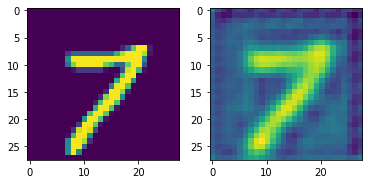

In [9]:
# Plot the input and output (i.e. reconstructed image)
idx = torch.randint(0, output.size(0), ())
pred = min_max_norm(output[idx, 0])
img = data[idx, 0]

fig, axarr = plt.subplots(1, 2)
axarr[0].imshow(img.detach().numpy())
axarr[1].imshow(pred.detach().numpy())


### Register hood to get network activations for a given input
We now need to register a forward hook on the model.

The hook will be called every time after forward() has computed an output. 
So the activation with the name specified will be saved after passing the data through the trained model.

You can register the hook in the following way:
```python
model.conv_name.register_forward_hook(get_activation('conv_name'))
```

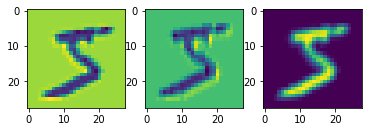

In [21]:
# Set up the hook for activations
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Register the hook with the convolutional layer of interest
model.conv1.register_forward_hook(get_activation('conv1'))
data, _ = dataset[0]
data.unsqueeze_(0)

# Run through model again, to save the relavent activation
output = model(data)

# Visualize the activation
act = activation['conv1'].squeeze()
fig, axarr = plt.subplots(1, act.size(0))
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx])


### Task 2: Visualise an activation of another convolutional layer
*Hint*: Look at the names for the layers when we first created our network

In [15]:
# --------------------------------------------- Task 2 --------------------------------------------------------
# write code here



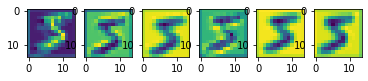

In [27]:
# Register the hook with the convolutional layer of interest
model.conv2.register_forward_hook(get_activation('conv2'))
data, _ = dataset[0]
data.unsqueeze_(0)

# Run through model again, to save the relavent activation
output = model(data)

# Visualize the activation
act = activation['conv2'].squeeze()
fig, axarr = plt.subplots(1, act.size(0))
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx])


## 3. CNN Layer Visualization

We will go through the next examples using code from the following repository https://github.com/utkuozbulak/pytorch-cnn-visualizations, which implements several well known visualization techniques for deep learning networks.

**CNN layer visualization** technique produces an image that minimizes the loss of a convolutional opteration for a specific layer and filter - i.e. it learns the image that optimally activates a particular convolutional filter.

**All the visualizations will be saved to /generated folder**

In [4]:
# load vgg model, and extract layers from the features modules only
pretrained_model = models.vgg16(pretrained=True).features


In [5]:
print(pretrained_model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [7]:
cnn_layer = 21
filter_pos = 5
# Fully connected layer is not needed
layer_vis = CNNLayerVisualization(pretrained_model, cnn_layer, filter_pos)

# Layer visualization with pytorch hooks
layer_vis.visualise_layer_with_hooks()

# Layer visualization without pytorch hooks
#layer_vis.visualise_layer_without_hooks()


Iteration: 1 Loss: 1.00
Iteration: 2 Loss: 0.54
Iteration: 3 Loss: -4.17
Iteration: 4 Loss: -7.75
Iteration: 5 Loss: -11.51
Iteration: 6 Loss: -14.92
Iteration: 7 Loss: -18.13
Iteration: 8 Loss: -21.20
Iteration: 9 Loss: -24.12
Iteration: 10 Loss: -26.99
Iteration: 11 Loss: -29.80
Iteration: 12 Loss: -32.58
Iteration: 13 Loss: -35.36
Iteration: 14 Loss: -38.08
Iteration: 15 Loss: -40.78
Iteration: 16 Loss: -43.45
Iteration: 17 Loss: -46.11
Iteration: 18 Loss: -48.76
Iteration: 19 Loss: -51.40
Iteration: 20 Loss: -54.00
Iteration: 21 Loss: -56.60
Iteration: 22 Loss: -59.23
Iteration: 23 Loss: -61.84
Iteration: 24 Loss: -64.49
Iteration: 25 Loss: -67.15
Iteration: 26 Loss: -69.82
Iteration: 27 Loss: -72.54
Iteration: 28 Loss: -75.27
Iteration: 29 Loss: -78.05
Iteration: 30 Loss: -80.81


### Task 3: Visualize different CNN layers and filters
Change the CNN layer and filter to visualize the network at different depths

In [ ]:
# --------------------------------------------- Task 3 --------------------------------------------------------
# write code here



## 4. Gradient visualization with Guided backpropagation


In [3]:
target_example = 0  # Snake
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
    get_example_params(target_example)

# Guided backprop
GBP = GuidedBackprop(pretrained_model)
# Get gradients
guided_grads = GBP.generate_gradients(prep_img, target_class)
# Save colored gradients
save_gradient_images(guided_grads, file_name_to_export + '_Guided_BP_color')
# Convert to grayscale
grayscale_guided_grads = convert_to_grayscale(guided_grads)
# Save grayscale gradients
save_gradient_images(grayscale_guided_grads, file_name_to_export + '_Guided_BP_gray')
# Positive and negative saliency maps
pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)
save_gradient_images(pos_sal, file_name_to_export + '_pos_sal')
save_gradient_images(neg_sal, file_name_to_export + '_neg_sal')
print('Guided backprop completed')


Guided backprop completed


## 5. Grad CAM


In [5]:
# Get params
target_example = 0  # Snake
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
    get_example_params(target_example)
# Grad cam
grad_cam = GradCam(pretrained_model, target_layer=11)
# Generate cam mask
cam = grad_cam.generate_cam(prep_img, target_class)
# Save mask
save_class_activation_images(original_image, cam, file_name_to_export)
print('Grad cam completed')


Grad cam completed


## 6. Deep Dream


In [6]:
# THIS OPERATION IS MEMORY HUNGRY! #
# Because of the selected image is very large
# If it gives out of memory error or locks the computer
# Try it with a smaller image
cnn_layer = 34
filter_pos = 94

im_path = './visualizations/input_images/dd_tree.jpg'
# Fully connected layer is not needed

dd = DeepDream(pretrained_model, cnn_layer, filter_pos, im_path)
# This operation can also be done without Pytorch hooks
# See layer visualisation for the implementation without hooks
dd.dream()


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\cherb/.cache\torch\checkpoints\vgg19-dcbb9e9d.pth
100%|███████████████████████████████████████████████████████████████████████████████| 548M/548M [00:42<00:00, 13.5MB/s]


Iteration: 1 Loss: 2.77
Iteration: 2 Loss: 0.61
Iteration: 3 Loss: -1.57
Iteration: 4 Loss: -5.64
Iteration: 5 Loss: -10.87
Iteration: 6 Loss: -14.60
Iteration: 7 Loss: -19.93
Iteration: 8 Loss: -22.96
Iteration: 9 Loss: -26.42
Iteration: 10 Loss: -36.34
(117, 224, 3)
Iteration: 11 Loss: -44.76
Iteration: 12 Loss: -48.59
Iteration: 13 Loss: -61.83
Iteration: 14 Loss: -68.44
Iteration: 15 Loss: -86.76
Iteration: 16 Loss: -99.98
Iteration: 17 Loss: -108.20
Iteration: 18 Loss: -120.65
Iteration: 19 Loss: -130.63
Iteration: 20 Loss: -140.53
(117, 224, 3)
Iteration: 21 Loss: -161.21
Iteration: 22 Loss: -171.47
Iteration: 23 Loss: -184.46
Iteration: 24 Loss: -197.56
Iteration: 25 Loss: -205.05
Iteration: 26 Loss: -230.14
Iteration: 27 Loss: -250.46
Iteration: 28 Loss: -269.46
Iteration: 29 Loss: -280.43
Iteration: 30 Loss: -294.50
(117, 224, 3)
Iteration: 31 Loss: -307.95
Iteration: 32 Loss: -325.44
Iteration: 33 Loss: -340.58
Iteration: 34 Loss: -361.21
Iteration: 35 Loss: -379.82
Iteration